In [1]:
import sys
sys.path.append("../src")

from jacks_amr import amr
import jax.numpy as jnp
import jax
import equinox as eqx
import matplotlib.pyplot as plt
import matplotlib as mpl
import timeit

from jacks_amr.flux_divergence import flux_divergence
from jacks_amr.refinement import refine_grid_for_function
from jacks_amr.indicators import approximate_gradient_indicator

In [2]:
def plot_amr_grid_func(f):
    grid = f.grid

    all_f_vals = jnp.concatenate([level_vals.flatten() for level_vals in f.level_values])
    cnorm = mpl.colors.Normalize(vmin=jnp.nanmin(all_f_vals), vmax=jnp.nanmax(all_f_vals))
    cmap = mpl.cm.viridis
    m = lambda x: cmap(cnorm(x))

    fig, ax = plt.subplots()

    for i, level in enumerate(grid.levels):
        dx = 1.0 / 6 / (2**i)
        spec = AMR.level_specs[i]
        x, y = level.block_indices
        coords = AMR.level_coordinates_lower[i]
        for j in range(level.n_active):
            block_indices = jax.tree.map(lambda a: a[j], level.block_indices)
            if block_indices[0] == -1:
                continue
            block_origin = grid.indices_to_origin(i, block_indices)
            block_active_idx = level.block_index_map[block_indices]
            for k1 in range(spec.block_shape[0]):
                for k2 in range(spec.block_shape[1]):
                    s1 = block_origin[0] + k1
                    s2 = block_origin[1] + k2
                    val = f.level_values[i][block_active_idx, k1, k2]
                    rect = mpl.patches.Rectangle(
                            (coords[0].flatten()[s1], coords[1].flatten()[s2]), dx, dx,
                            linewidth=1,
                            edgecolor='r',
                            facecolor=m(val))
                    ax.add_patch(rect)

    return fig

In [3]:
n_levels = 5

L0_shape = (6, 6)

level_specs = [amr.AMRLevelSpec(0, L0_shape, 1, (6, 6))] + [
    amr.AMRLevelSpec(i, L0_shape, min(80, 9*(4**i)), (2, 2)) for i in range(1, 5)
]

AMR = amr.AMRGridFactory(5, 1, (6, 6),
                         (0., 0.), (1., 1.), level_specs)

def f_init(x, y):
    return jnp.tanh(-(jnp.sqrt(x**2 + y**2) - 0.7) / 0.1)

    
def flux(q_in, q_out, normal):
    u = jnp.array([0.4, 0.9])
    return 0.5 * (q_in + q_out) + (jnp.dot(u, normal))
    
copyout_bcs = lambda coords, copyout_values: copyout_values

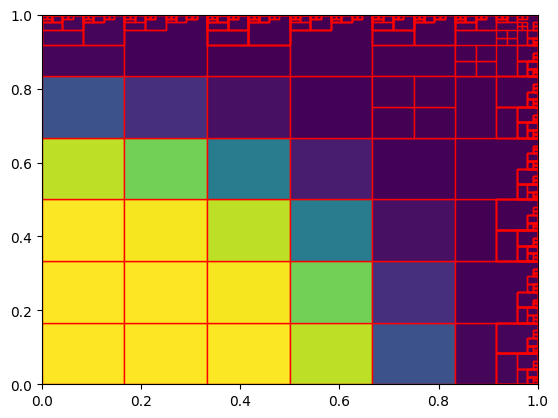

In [4]:
def criterion(coarse, fine):
    return jnp.sqrt(jnp.sum(jnp.abs(coarse - fine)**2))
    
grid = AMR.refine_to_approximate(f_init, criterion)
f = grid.approximate(f_init)
# f = refine_grid_for_function(f0, copyout_bcs, approximate_gradient_indicator)
# f = refine_grid_for_function(f, copyout_bcs, approximate_gradient_indicator)

fig = plot_amr_grid_func(f)

In [5]:
def criterion(coarse, fine):
    return jnp.sqrt(jnp.sum(jnp.abs(coarse - fine)**2))
    
grid = AMR.refine_to_approximate(f_init, criterion)
f = grid.approximate(f_init)
f = refine_grid_for_function(f, copyout_bcs, approximate_gradient_indicator)
# f = refine_grid_for_function(f, copyout_bcs, approximate_gradient_indicator)

fig = plot_amr_grid_func(f)

NameError: name 'grid' is not defined